In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.integrate import cumtrapz

In [ ]:
# processamento RBR praia de caopacabana

import pandas as pd
import matplotlib.pyplot as plt

plt.close('all')

# pth = 'teste_copacabana_20240921/RBR/055161_20240921_1904.xlsx'
pth = '../dados/teste_copacabana_20240929/RBR/055161_20240929_1733.xlsx'

df = pd.read_excel(pth,
        sheet_name='Bursts', header=1)

df.index = pd.to_datetime(df.Time, format="%Y-%m-%d %H:%M:%S.%f")

df.index.name = 'time'

In [ ]:
df.Wave.plot(ylabel='Heave [m]', grid='on')

plt.show(block=False)


In [88]:
ax = pd.read_table('../dados/TEBIG_gx3/TOA5_55915.microstrain_stbacelX.dat', skiprows=4,
                   sep=',', header=None, parse_dates = {'date':[0]}, index_col='date').T

ay = pd.read_table('../dados/TEBIG_gx3/TOA5_55915.microstrain_stbacelY.dat', skiprows=4,
                   sep=',', header=None, parse_dates = {'date':[0]}, index_col='date').T

az = pd.read_table('../dados/TEBIG_gx3/TOA5_55915.microstrain_stbacelZ.dat', skiprows=4,
                   sep=' ', header=None, parse_dates = {'date':[0, 1]}, index_col='date').T

time = az.index.values

# ax.shape
ax = ax.iloc[1:, 18].values
ay = ay.iloc[1:, 18].values
az = az.iloc[1:, 18].values

In [90]:
# Função para cálculo do filtro passa-baixa
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Aplica o filtro passa-baixa
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Função para cálculo de pitch e roll
def calculate_pitch_roll(ax, ay, az):
    pitch = np.arctan2(ax, np.sqrt(ay**2 + az**2))  # Inclinação no eixo x
    roll = np.arctan2(ay, np.sqrt(ax**2 + az**2))   # Inclinação no eixo y
    return pitch, roll

# Função para correção de gravidade na aceleração vertical
def correct_acceleration_az(ax, ay, az, pitch, roll):
    g = 9.81  # Aceleração gravitacional
    az_corr = az - (g * np.cos(pitch) * np.cos(roll))  # Corrige o efeito da gravidade
    return az_corr

# Função para calcular o heave a partir da aceleração corrigida
def calculate_heave(az_corr, dt):
    # Integração da aceleração corrigida para obter a velocidade
    vz = cumtrapz(az_corr, dx=dt, initial=0)
    
    # Integração da velocidade para obter o heave
    heave = cumtrapz(vz, dx=dt, initial=0)
    
    return heave

# Dados de exemplo: ax, ay, az (acelerações) e tempo (em segundos)
# Esses dados precisam ser carregados a partir dos seus arquivos
# ax = np.array([...])  # Aceleração no eixo x
# ay = np.array([...])  # Aceleração no eixo y
# az = np.array([...])  # Aceleração no eixo z
# time = np.array([...])  # Tempo correspondente aos dados de aceleração

dt = np.mean(np.diff(time))  # Intervalo de tempo médio entre as amostras
fs = 1 / dt  # Frequência de amostragem

# Parâmetros do filtro
cutoff_freq = 0.2  # Frequência de corte em Hz (ajuste conforme necessário)

# Calcular pitch e roll
pitch, roll = calculate_pitch_roll(ax, ay, az)

# Corrigir a aceleração vertical (az) para remover o efeito da gravidade
az_corr = correct_acceleration_az(ax, ay, az, pitch, roll)

# Aplicar um filtro passa-baixa para remover ruídos
az_corr_filtered = lowpass_filter(az_corr, cutoff=cutoff_freq, fs=fs)

# Calcular o heave
heave = calculate_heave(az_corr_filtered, dt)

# Exibir os resultados
print("Série de Heave:")
print(heave)



Série de Heave:
[ 0.00000000e+00 -5.40434037e+00 -2.16123743e+01 ... -5.62416410e+06
 -5.63518652e+06 -5.64621975e+06]


/tmp/ipykernel_73213/2777264714.py:29: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  vz = cumtrapz(az_corr, dx=dt, initial=0)
/tmp/ipykernel_73213/2777264714.py:32: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  heave = cumtrapz(vz, dx=dt, initial=0)


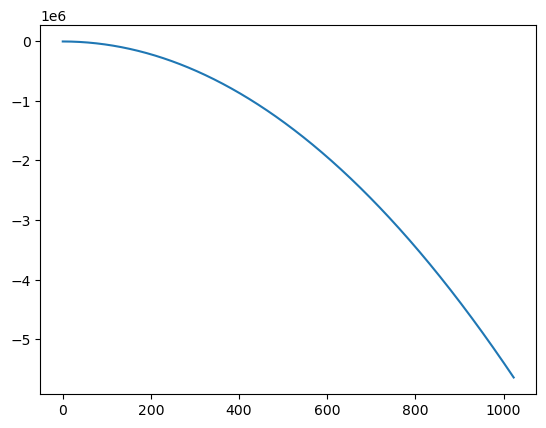

In [91]:
plt.plot(heave)